Import Necessary Packages

In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import pylab
import set_plotly_credentials as setply
from sklearn.cluster import KMeans

In [2]:
setply.set_plotly_credentials('credentials.json')

Read in Necessary Dataset

In [133]:
data=pd.read_csv('~/Documents/capstone/not-that-into-you/dating.csv',encoding='latin1')

Choose which variables you want to cluster on.

In [292]:
bio_info=data[['iid','pid','match','age','sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga','exphappy']]

In [293]:
bio_info=bio_info.dropna(how='any')

Only keep one line of background information data for each participant.

In [462]:
bio_info_subset=bio_info.drop_duplicates(subset='iid')

Select Out the Speed-Dating Matches for Links

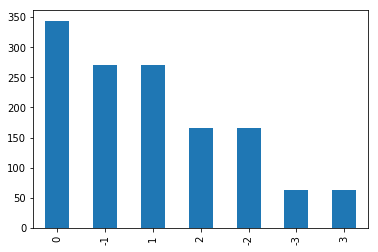

In [480]:
matches=bio_info[['iid','pid','match']]
matches=matches[matches.match==1]
matches['pid']=matches['pid'].astype(int)
matches = matches[matches.iid.isin(bio_info_subset.iid)&matches.pid.isin(bio_info_subset.iid)]
edges = list(zip(matches.iid,matches.pid))


Perform K-means clustering. Normalize and generate cluster labels.

In [494]:
generate_clusters(bio_info_subset,['age','sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga','exphappy'],3,'cluster_assignment')

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,iid,pid,match,age,sports,tvsports,exercise,dining,museums,art,...,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,cluster_assignment
0,1,11.0,0,21.0,9.0,2.0,8.0,9.0,1.0,1.0,...,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,0
10,2,11.0,0,24.0,3.0,2.0,7.0,10.0,8.0,6.0,...,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0,4.0,1
20,3,11.0,0,25.0,3.0,8.0,7.0,8.0,5.0,5.0,...,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0,4.0,2
30,4,11.0,0,23.0,1.0,1.0,6.0,7.0,6.0,7.0,...,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0,1.0,2
40,5,11.0,0,21.0,7.0,4.0,7.0,7.0,6.0,8.0,...,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0,7.0,2
50,6,11.0,0,23.0,10.0,8.0,9.0,7.0,8.0,7.0,...,9.0,2.0,5.0,6.0,6.0,4.0,1.0,1.0,4.0,0
60,7,11.0,0,22.0,5.0,3.0,4.0,10.0,10.0,10.0,...,8.0,8.0,10.0,10.0,10.0,10.0,10.0,10.0,7.0,2
70,8,11.0,0,25.0,2.0,2.0,1.0,10.0,9.0,9.0,...,8.0,10.0,9.0,9.0,6.0,6.0,8.0,6.0,6.0,2
80,9,11.0,0,26.0,4.0,3.0,1.0,8.0,6.0,7.0,...,8.0,8.0,10.0,10.0,9.0,9.0,8.0,3.0,6.0,2
90,10,11.0,0,26.0,9.0,9.0,9.0,7.0,6.0,6.0,...,8.0,5.0,6.0,7.0,7.0,8.0,7.0,7.0,7.0,2


In [495]:
network_graph(bio_info_subset.iid,edges,bio_info_subset.cluster_assignment)

In [496]:
generate_plotly(G)

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~1215Diana/0 or inside your plot.ly account where it is named 'networkx'


In [ ]:
new = pd.DataFrame.from_dict(cluster, orient='index').reset_index()
new.rename(columns={'index': 'iid', 0: 'cluster'}, inplace=True)
together=pd.merge(new,matches,left_on=new.iid,right_on=matches.iid,how='right')
together2=pd.merge(together,new,left_on=together.pid,right_on=new.iid,how='left')
together2=together2.groupby(['iid_x', 'iid']).last()
together2['difference']=together2.cluster_x-together2.cluster_y
together2['difference'].value_counts().plot( kind='bar')
plt.show()